# INFO-F-422 -  Statistical Foundations of Machine Learning 

### De Vos Sebastien - __[sebastien.de.vos@ulb.be](mailto:student1@ulb.ac.be) - Student ID 459907__
### Kalai Tarik - __[Tarik.Kalai@ulb.be](mailto:student2@ulb.ac.be) - Student ID 459631__
### Rubas Diego - __[Diego.Rubas@ulb.be](mailto:student3@ulb.ac.be) - Student ID 459733__

### Video presentation: www.youtube.com/abcd1234

## Project Title


# Introduction


# Exploratory Data Anaylsis

In this section we will be viewing and understanding the data that we have.

### Data recuperation

In [2]:
training_set_features <- read.csv("sample_data/training_set_features.csv", stringsAsFactors  = T)
training_set_labels <- read.csv("sample_data/training_set_labels.csv", stringsAsFactors  = T)
test_set_features <- read.csv("sample_data/test_set_features.csv", stringsAsFactors  = T)
submission_format<- read.csv("sample_data/submission_format.csv", stringsAsFactors  = T)


### Dimensions of the data samples. 

In [4]:


cat("dimension of test_set_features: ",  dim(test_set_features), "\n")# This will be the input to the model (after it had been trained), the answer the model
#will be providing will then be sent to DrivenData. 

cat("dimension of training_set_labels: ", dim(training_set_labels), "\n") # Answers to training_set_features. 

cat("dimension of training_set_features : ", dim(training_set_features), "\n") # Corresponding to a sample of data: will be used for training set and test set. 
#The result will then be "validated" with a comparison with training_set_labels




dimension of test_set_features:  26708 36 
dimension of training_set_labels:  26707 3 
dimension of training_set_features :  26707 36 


### Data preview

In [4]:
# head(training_set_features)

# summary(training_set_features)

# dim(na.omit(training_set_features))

# apply(is.na(training_set_features),2, any)

# for the feature: h1n1_concern it has been decided that a mean (sum of all values different of NA and then divide by the total number of variables) 
# will be computed for the Null values knowing that there is 0.34 % of missing values. 

length <- dim(training_set_features)[1]
count_NA <- 0
non_NA_var <- 0
c0 <- 0
c1 <- 0
c2 <- 0
c3 <- 0

for (i in 1:length){
  id <- training_set_features[i, 1]
  var <- training_set_features[i,2]
  if(is.na(var)){
    count_NA <- count_NA + 1
  }
  else if(var == 0){
    c0 <- c0 +1
    non_NA_var <- non_NA_var + var
  }
  else if(var == 1){
    c1 <- c1 +1
    non_NA_var <- non_NA_var + var

  }
  else if(var == 2){
    c2 <- c2 +1
    non_NA_var <- non_NA_var + var
  }
  else if(var == 3){
    c3 <- c3 +1
    non_NA_var <- non_NA_var + var
  }
}

mean_TS <- mean(training_set_features[,2], na.rm = T) # Mean des val. NA
sd_TS <- sqrt(var(training_set_features[,2], na.rm = T))  # Ecart type des valeurs NA
mean_TS
sd_TS
empirical_mean <- (non_NA_var)/(length-count_NA)
cat("Mean for NA values :", empirical_mean, "\n")
cat("Ratio of missing values: ", (count_NA/length)*100, "\n")
cat("Number of missing values: ", count_NA, "\n")

cat("here: ", sum(is.na(training_set_features[,2])), "\n")
training_set_features[is.na(training_set_features[,2]), 2] <- round(mean_TS + sd_TS/2)
mean(training_set_features[,2], na.rm = T) # Mean des val. NA
sqrt(var(training_set_features[,2], na.rm = T)) 

print(sum(is.na(training_set_features[,2])))

# pos_val <- (length-count_NA)
# pz <- c(c0/pos_val, c1/pos_val, c2/pos_val, c3/pos_val)
# ez <- 1*pz[2] + 2*pz[3] + 3*pz[4]
# sd_w <- sqrt((0-ez)^2*pz[1] + (1 - ez)^2 * pz[2] + (2 - ez)^2 * pz[3] + (3 - ez)^2 * pz[4])
# cat("c0: ", c0, "c1: ", c1, "c2: ", c2, "c3: ", c3, "\n")
# cat("Variance :", sd_w, "\n")
# N <-length
# for( i in 2:24){
#   cat("results:", "\n")
#   unique(training_set_features[i]))
# }
unique(training_set_features[4])

# test <- list(names(training_set_features)[1])

[1] 1.618486

[1] 0.9103107

Mean for NA values : 1.618486 
Ratio of missing values:  0.344479 
Number of missing values:  92 
here:  92 


[1] 1.6198

[1] 0.9090163

[1] 0


,behavioral_antiviral_meds
,<int>
1,0
24,1
137,NA


In [5]:
# unique(training_set_features[36])
# mean(training_set_features[,1], na.rm = T)
length(which(is.na(training_set_features[,3])))

[1] 116

In [276]:


# To generalise the function we need to take into account the empty answers and not only NA. 
training_set_features <- read.csv("sample_data/training_set_features.csv", stringsAsFactors  = T)
cleanData <- function(x) {
    res <- list()
    for (i in 2:22) {
        x <- transform_na(x, i)
    }
    return(x) #return
}

transform_na <- function(x, index){
    if (length(which(is.na(x[,index]))) > 0) { #Check if there is any NA in the column
            mean_ts <- mean(x[,index], na.rm = T) #compute old_mean
            sd_ts <- sqrt(var(x[,index], na.rm = T)) #compute old_sd
            feature_name<- names(x[index]) #remember the name of the feature we are dealing with
            x[is.na(x[,index]), index] <- round(mean_ts + sd_ts/2) #modify the data 
        }
    return(x)
}

norm<-function(x){
    return( (x-min(x)) / (max(x)-min(x)) )
}

one_hot_encoding <- function(x, index) {
    names <- levels(x[,index]) # get the names of all the possible different values
    new_col <- model.matrix(~0+x[,index]) # transforms the colmumn in a matrix with a one in the correct column and 0 otherwise
    attr(new_col, "dimnames")[[2]] <- names
    new_col <- as.data.frame(new_col)
    x <- data.frame(x[1:index-1],new_col,x[(index+1):ncol(x)])
    return(x)
}

cast_into_double <- function(x){
    for (i in 2:length(x)){
        x[,i] <- as.double(x[,i])
    }
    return(x)
}

# training_set_features <- cleanData()



In [284]:
training_set_features <- read.csv("sample_data/training_set_features.csv", stringsAsFactors  = T)

# preprocessing <- function(x) {
#     x <- cleanData(training_set_features)
#     for (i in 2:length(x)){
#         levels(x[,i]) <- switch(
#             i,
#             23 = levels(x[,i]) <- c(1, 2, 3, 4, 5), 
#             24 = levels(x[,i]) <- c(0, 1, 2, 4, 3),
#             31 =  levels(x[,i]) <- c(0, 2, 1, 3), 
#         )

#         if (i == 25 || i = 29) { #Not going to work, need to think about it
#            x <- one_hot_encoding(x, i)
#         }
#         else if (i == 32) {
#            levels(x[,i])[1] <- 'marital_status_not_specified'
#            x <- one_hot_encoding(x, 32)
#         }
#         else if (i == 35) {
#            levels(x[,i])[1] <- 'rental_not_specified'
#             x <- one_hot_encoding(x, i)
#         }
#         else if (i == 38) {
#            levels(training_set_features[,i])[1] <- 'employment_not_specified'
#             training_set_features <- one_hot_encoding(training_set_features, i)
#         }
#         else if (i == 42) {
#            x <- subset(training_set_features, select = -i)
#         }
#     }
# }

# for feature 2 -> 22
training_set_features <- cleanData(training_set_features)
# for feature 23
levels(training_set_features[,23]) <- c(1, 2, 3, 4, 5)

# for feature 24
levels(training_set_features[,24]) <- c(0, 1, 2, 4, 3)

# for feature 25
training_set_features <- one_hot_encoding(training_set_features, 25)

# for feature 26 -> number 29
training_set_features <- one_hot_encoding(training_set_features, 29)

# for feature 27 -> number 31 !!! it need to be changed, it is not a good way to sort this data.
levels(training_set_features[,31]) <- c(0, 2, 1, 3) 

# for feature 28 -> number 32
levels(training_set_features[,32])[1] <- 'marital_status_not_specified'
training_set_features <- one_hot_encoding(training_set_features, 32)

# for feature 29 -> number 35
levels(training_set_features[,35])[1] <- 'rental_not_specified'
training_set_features <- one_hot_encoding(training_set_features, 35)

#for features 30 -> number 38
levels(training_set_features[,38])[1] <- 'employment_not_specified'
training_set_features <- one_hot_encoding(training_set_features, 38)
 
# for feature 31 -> 42, we judged its contribution was negligeable against its cost of implementation
training_set_features <- subset(training_set_features, select = -42)

# for feature 32 -> 42 (since we dropped last column
training_set_features <- one_hot_encoding(training_set_features, 42)

# for feature 33 -> 45
training_set_features <- transform_na(training_set_features, 45)

# for feature 34 -> 46
training_set_features <- transform_na(training_set_features, 46)

# for feature 35 -> 47, we judged its contribution was negligeable against its cost of implementation
training_set_features <- subset(training_set_features, select = -47)

# for feature 36 -> 47, we judged its contribution was negligeable against its cost of implementation
training_set_features <- subset(training_set_features, select = -47)



training_set_features <- cast_into_double(training_set_features)
name <- names(training_set_features)[-1]
temp <- apply(training_set_features[2:length(training_set_features)], 2 , norm)
attr(temp, "dimnames")[[2]] <- name
training_set_features <- data.frame(training_set_features[1],as.data.frame(temp))


head(training_set_features[40:46])

,Not.in.Labor.Force,Unemployed,MSA..Not.Principle..City,MSA..Principle.City,Non.MSA,household_adults,household_children
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0,0,0,1,0.0000000,0
2,0,0,1,0,0,0.0000000,0
3,0,0,1,0,0,0.6666667,0
4,1,0,0,1,0,0.0000000,0
5,0,0,1,0,0,0.3333333,0
6,0,0,0,1,0,0.6666667,1


In [205]:
training_set_features <- read.csv("sample_data/training_set_features.csv", stringsAsFactors  = T)

index = 35

#training_set_features <- transform_na(training_set_features, index)
head(training_set_features[index])
print(unique(training_set_features[index]))
cat("number of na values: ", sum(is.na(training_set_features[, index])), "\n")
table(training_set_features[index])
levels(training_set_features[,index])
# df[df==""]<-NA

levels(training_set_features[,index])[1] <- 'marital_status_not_specified'
# names <- levels(training_set_features[,index])
# new_col <- model.matrix(~0+training_set_features[,index])
# attr(new_col, "dimnames")[[2]] <- names
# new_col <- as.data.frame(new_col)
# training_set_features <- subset(training_set_features, select = -index)

# training_set_features<-data.frame(training_set_features[1:index-1],new_col,training_set_features[index:ncol(training_set_features)])


# attr(training_set_features[,index], "dimnames")[[2]] <- names
# training_set_features[,index]
# training_set_features[,index] <- replace(training_set_features[,index], training_set_features[,index]=='', NA)
# levels(training_set_features[,index]) <- c(1, 2, 3, 4, 5)
table(training_set_features[index]) 
head(training_set_features[,index])
head(training_set_features[23:29])

# data_omit <- na.omit(data)

dim(training_set_features)
# 8056 14723  2803  1125 


,employment_industry
,<fct>
1,
2,pxcmvdjn
3,rucpziij
4,
5,wxleyezf
6,saaquncn


    employment_industry
1                      
2              pxcmvdjn
3              rucpziij
5              wxleyezf
6              saaquncn
7              xicduogh
14             ldnlellj
19             wlfvacwt
31             nduyfdeo
42             fcxhlnwr
45             vjjrobsf
53             arjwrbjb
57             atmlpfrs
62             msuufmds
71             xqicxuve
117            phxvnwax
143            dotnnunm
144            mfikgejo
157            cfqqtusy
187            mcubkhph
308            haxffmxo
758            qnlwzans
number of na values:  0 



         arjwrbjb atmlpfrs cfqqtusy dotnnunm fcxhlnwr haxffmxo ldnlellj 
   13330      871      926      325      201     2468      148     1231 
mcubkhph mfikgejo msuufmds nduyfdeo phxvnwax pxcmvdjn qnlwzans rucpziij 
     275      614      124      286       89     1037       13      523 
saaquncn vjjrobsf wlfvacwt wxleyezf xicduogh xqicxuve 
     338      527      215     1804      851      511 

[1] ""         "arjwrbjb" "atmlpfrs" "cfqqtusy" "dotnnunm" "fcxhlnwr"
 [7] "haxffmxo" "ldnlellj" "mcubkhph" "mfikgejo" "msuufmds" "nduyfdeo"
[13] "phxvnwax" "pxcmvdjn" "qnlwzans" "rucpziij" "saaquncn" "vjjrobsf"
[19] "wlfvacwt" "wxleyezf" "xicduogh" "xqicxuve"


marital_status_not_specified                     arjwrbjb 
                       13330                          871 
                    atmlpfrs                     cfqqtusy 
                         926                          325 
                    dotnnunm                     fcxhlnwr 
                         201                         2468 
                    haxffmxo                     ldnlellj 
                         148                         1231 
                    mcubkhph                     mfikgejo 
                         275                          614 
                    msuufmds                     nduyfdeo 
                         124                          286 
                    phxvnwax                     pxcmvdjn 
                          89                         1037 
                    qnlwzans                     rucpziij 
                          13                          523 
                    saaquncn                     vjjrob

[1] marital_status_not_specified pxcmvdjn                    
[3] rucpziij                     marital_status_not_specified
[5] wxleyezf                     saaquncn                    
22 Levels: marital_status_not_specified arjwrbjb atmlpfrs cfqqtusy ... xqicxuve

,age_group,education,race,sex,income_poverty,marital_status,rent_or_own
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own
2,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent
3,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own
4,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent
5,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own
6,65+ Years,12 Years,White,Male,"<= $75,000, Above Poverty",Married,Own


[1] 26707    36

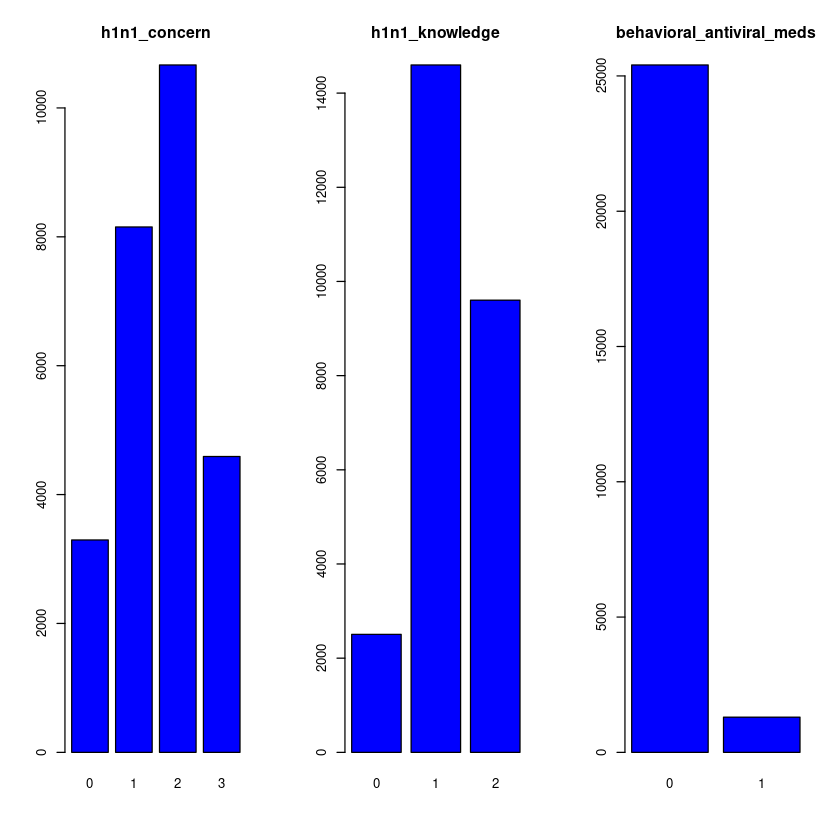

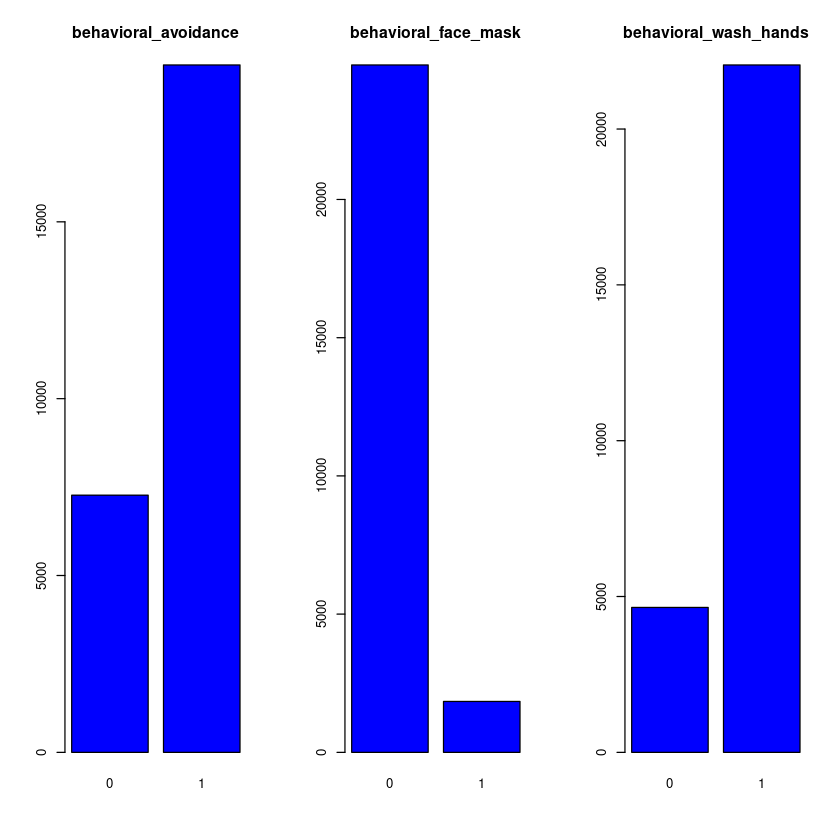

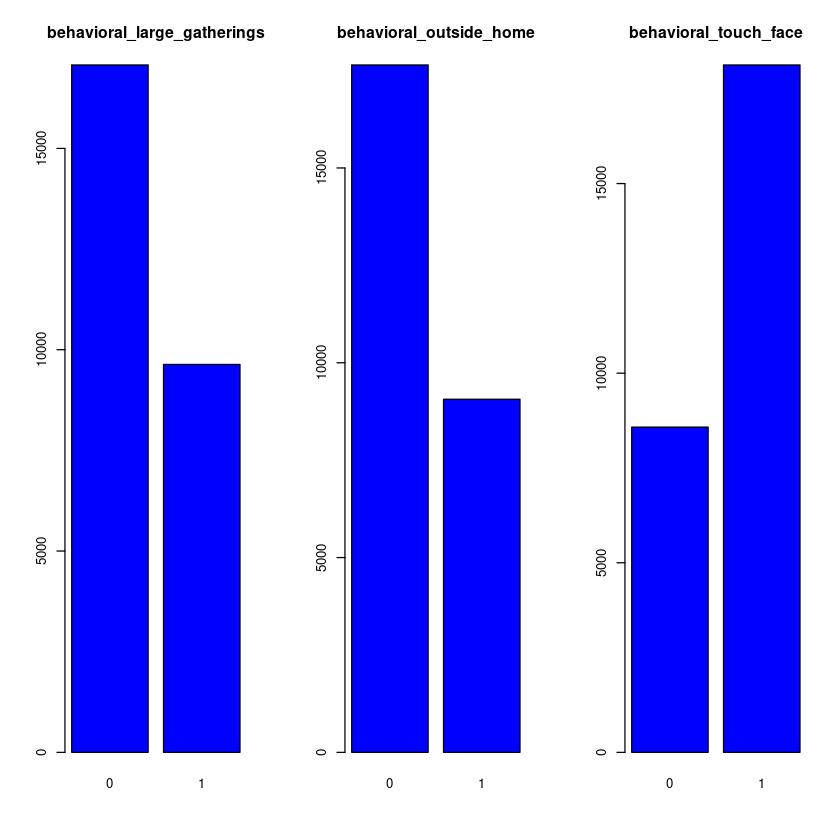

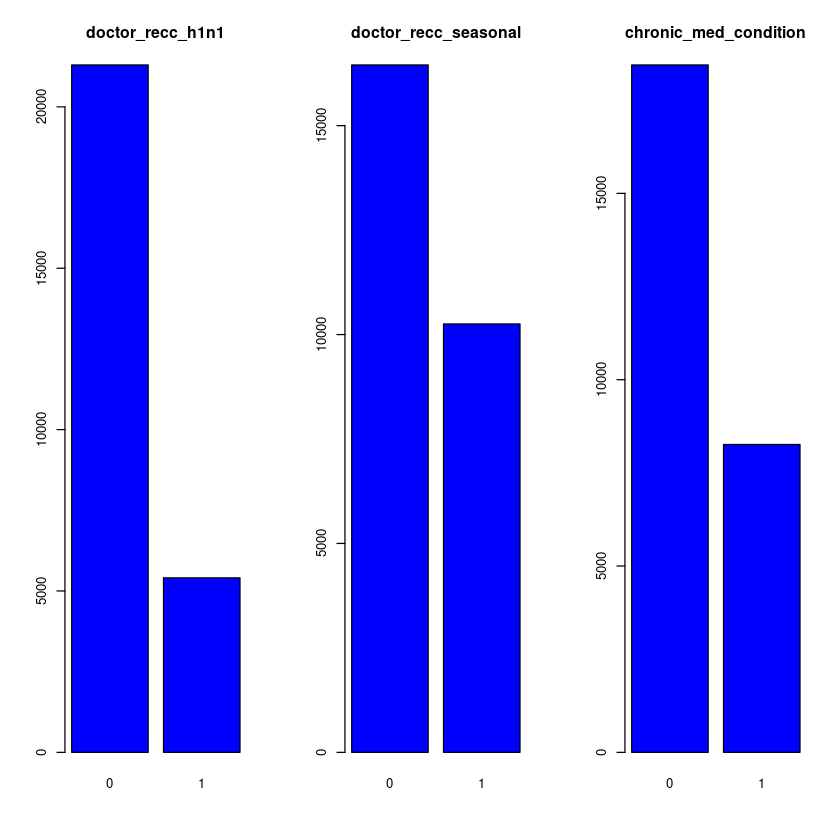

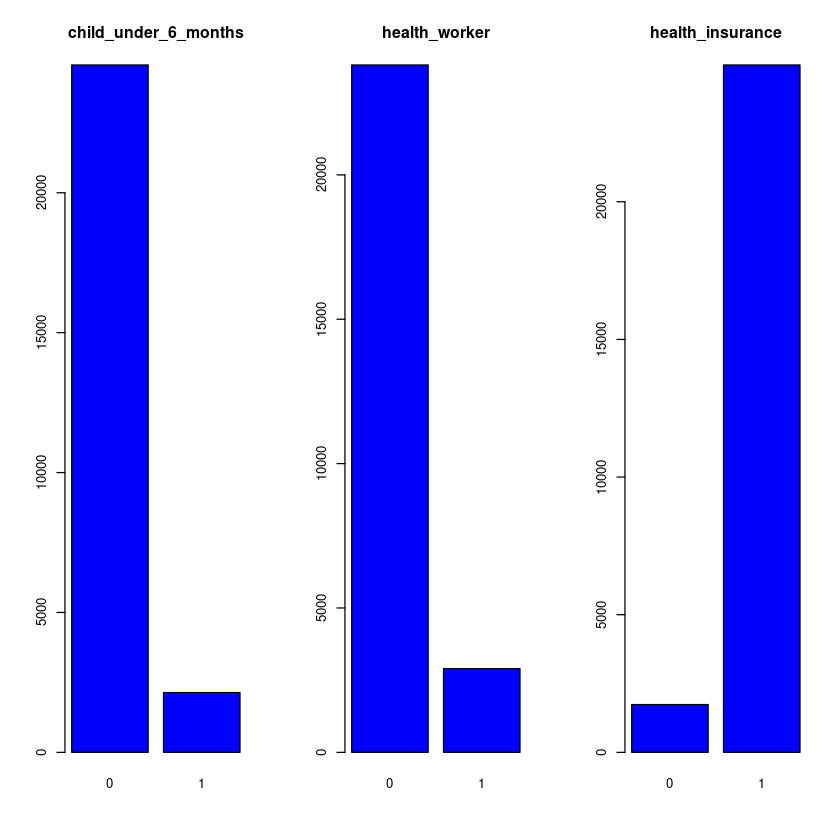

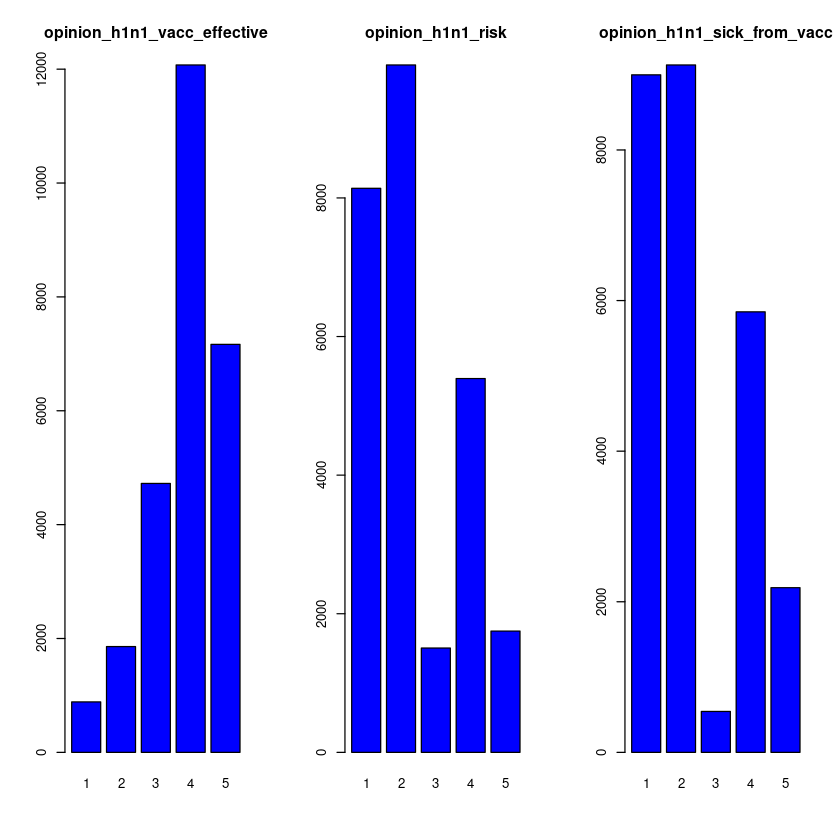

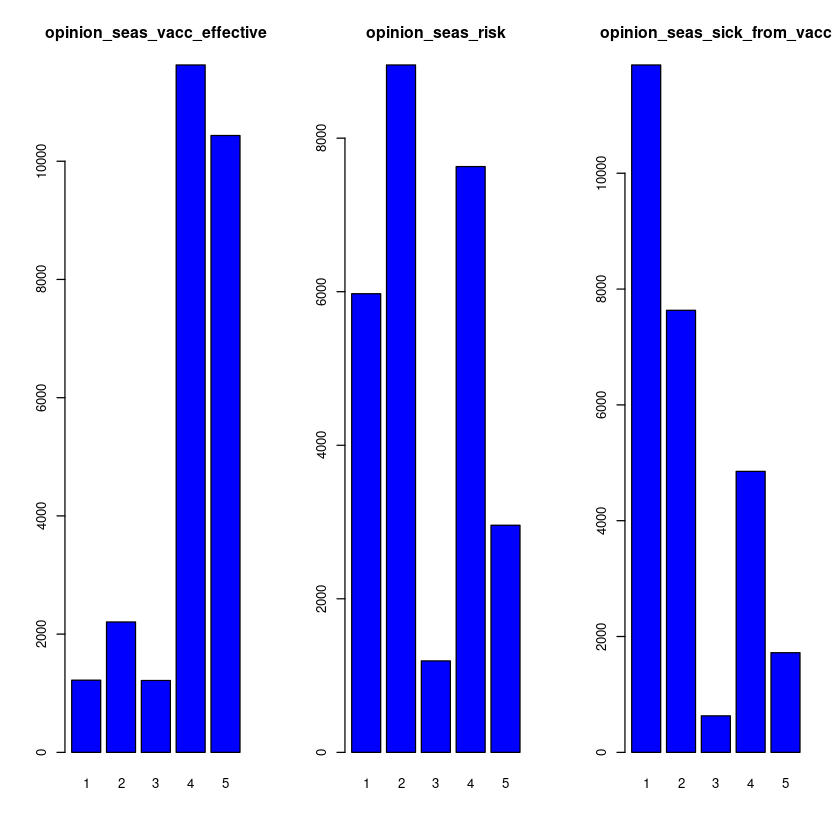

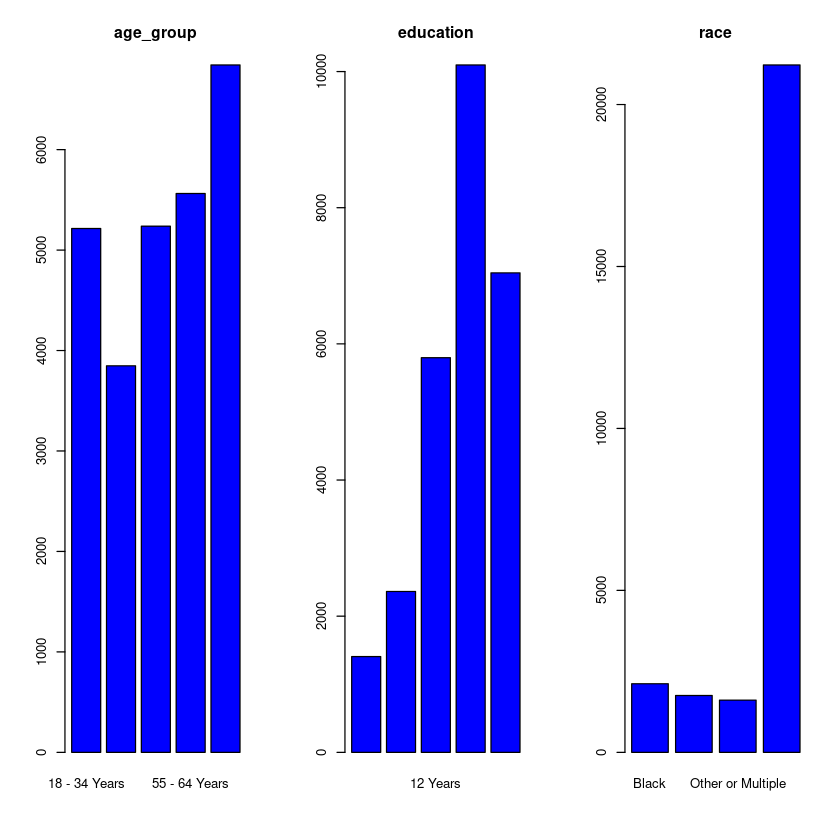

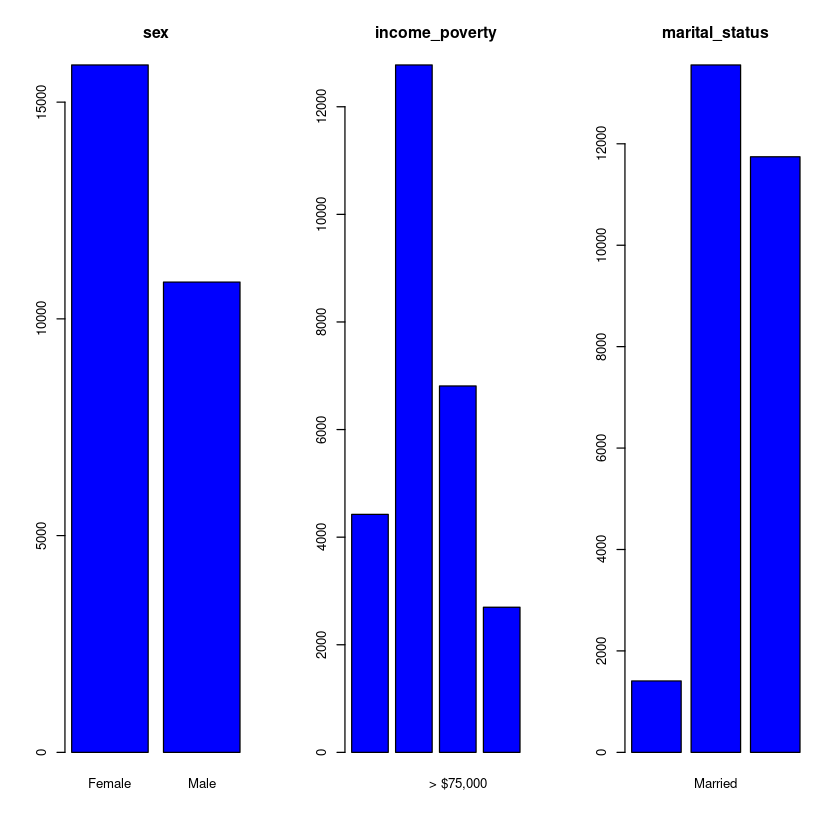

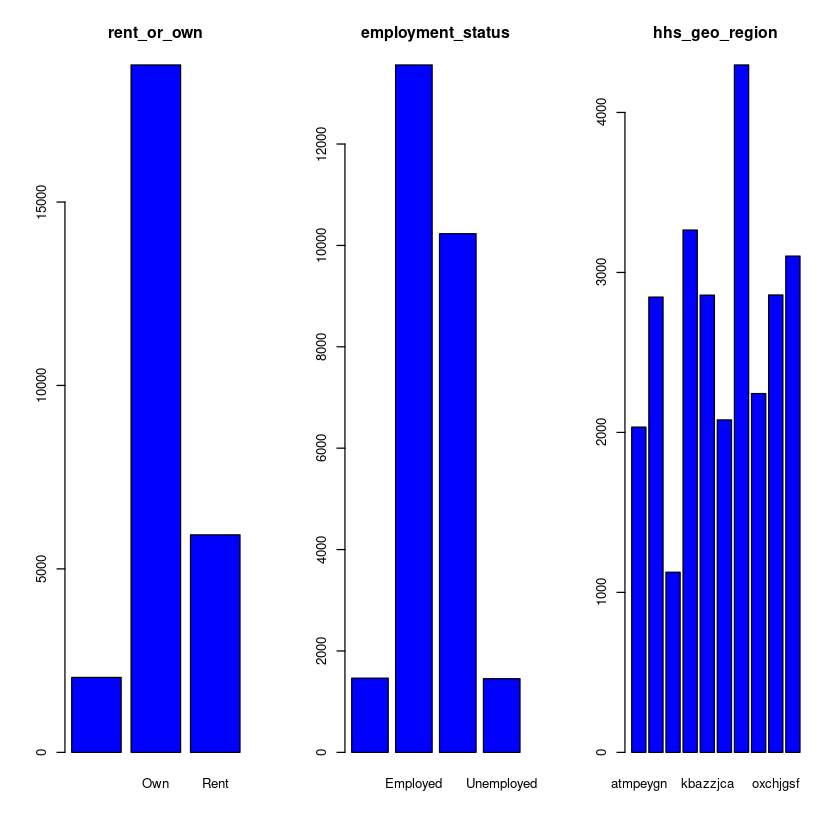

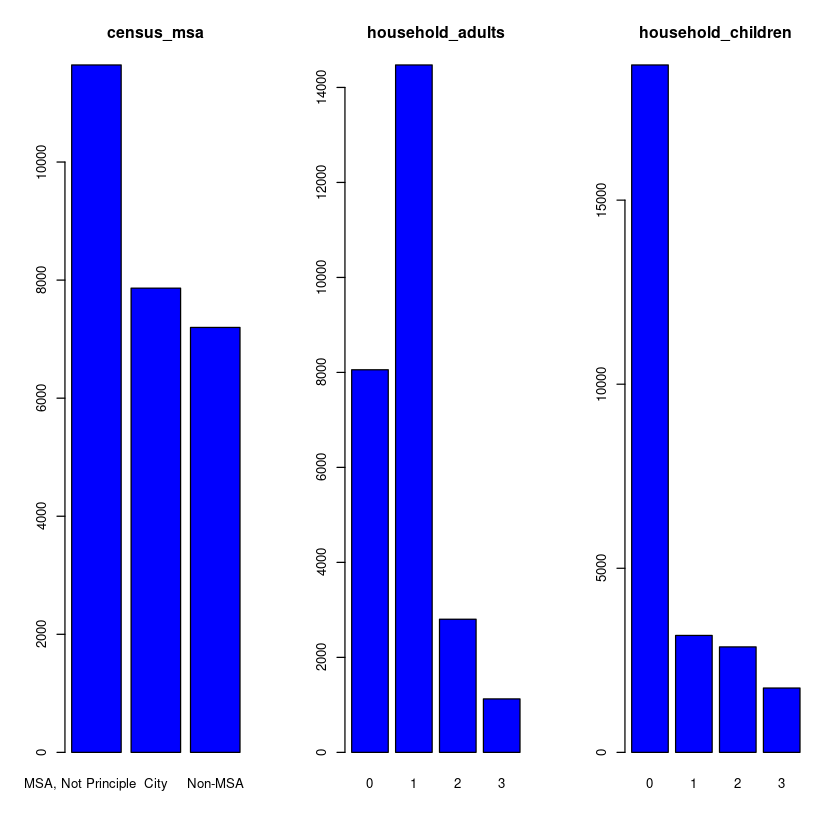

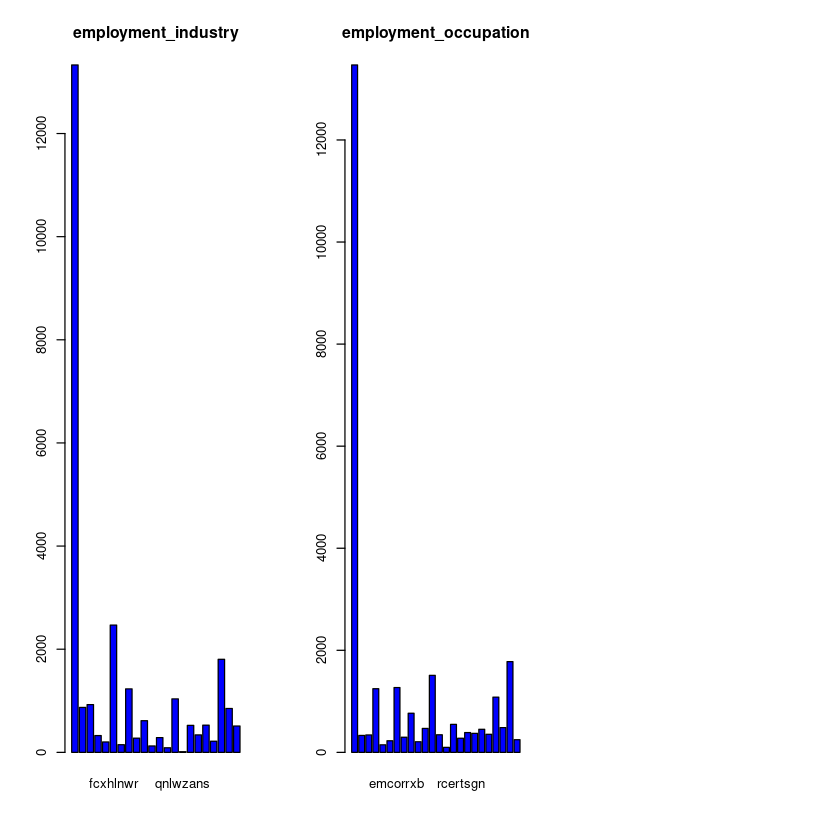

In [21]:
par(mfrow=c(1,3))

# data_to_plot <- table(training_set_features["h1n1_concern"])
# data_to_plot <- table(t(training_set_features["h1n1_knowledge"]))

names<-names(training_set_features)
for(i in 2:length(names)){
barplot(table(training_set_features[names[i]]), col="blue", main=names[i],beside=T)
    
}



In [ ]:
# Normalisation 

#X_norm = (x - x_min)/(x_max - x_min) #To do only for the "broken data" => see plot. 

# Data preprocessing

## Missing value imputation

## Feature engineering

## Feature selection



# Model selection

## Model 1

## Model 2

## Model 3

#### Example of simple equation
\begin{equation}
e = mc^2
\end{equation}

#### Example of matrix equation - Cross product formula:

\begin{equation*}
\mathbf{V}_1 \times \mathbf{V}_2 =  
\begin{vmatrix}
\mathbf{i} & \mathbf{j} & \mathbf{k} \\
\frac{\partial X}{\partial u} &  \frac{\partial Y}{\partial u} & 0 \\
\frac{\partial X}{\partial v} &  \frac{\partial Y}{\partial v} & 0
\end{vmatrix}
\end{equation*}

#### Example of multiline equation - The Lorenz Equations:

\begin{align}
\dot{x} & = \sigma(y-x) \\
\dot{y} & = \rho x - y - xz \\
\dot{z} & = -\beta z + xy
\end{align}

#### Example of Markdown Table:

| This | is   |
|------|------|
|   a  | table|


# Alternative models





# Conclusions